This notebook is used to analyse the assessor labels collected via the online assessment. 

I will try to answer the following questions:

**Query related**

1. How many queries were assessed?
2. How many queries had 3 or more different assessors?
3. How many terms had each query?
4. What type of queries were there?
5. How many queries had the MS MARCO relevant passage in the top 20?

**Assessor Related**

1. How many assessors contributed?
2. How was there English level?
3. Did any low English level (<6) assessors assess the same queries?
4. How many queries did each assessor assess?
5. How many queries are assessed by low English level assessors?
6. What is the number of assessors per query? 

**Assessment Related**

1. Are there any missing data?
2. How many times do the assessors disagree with the MS MARCO label (graded)?
3. How many times do the assessors disagree with the MS MARCO label (binary threshold=2)?
4. How many times do the assessors disagree with the MS MARCO label (binary thrheshold=3)?
5. How many times is the MS MARCO relevant passage the only relevant (graded?)
6. How many times is the MS MARCO relevant passage the only relevant (binary threshold=2)?
7. How many times is the MS MARCO relevant passage the only relevant (binary thrheshold=3)?
8. What are the number of queries that can be used for experiments (graded; threshold=2; threshold=3)?

**Experiment Dataset Stats**

1. How many queries does the dataset contain?
2. What is the number of assessors per query?
3. How many term does each query contain?
4. What type of queries does the dataset contain?
5. How many queries have the MS MARCO relevant passage in the top 20?
6. How many queries are assessed by low English level assessors?

## Import Libraries

In [1]:
import pandas as pd
import json
import numpy as np
from collections import Counter

## Load Data

In [2]:
# filenames
firebase_data = 'data.json'
query_subset_filename = 'queries.dev.small.tsv'
qrels_filename = 'qrels.dev.small.tsv'
bm25_filename = 'run_development_top100.tsv'
assessor_info = 'assessor_info.tsv'

In [3]:
with open(firebase_data, 'r') as infile:
    data = json.load(infile)
query_ids = list(data.keys())

In [4]:
query_subset = pd.read_csv(query_subset_filename,delimiter='\t',encoding='utf-8', header=None)
query_subset.columns = ['query_id', 'query']

In [5]:
bm25_df = pd.read_csv(bm25_filename,delimiter='\t',encoding='utf-8',header=None)
bm25_df.columns = ['query_id', 'passage_id','bm25_rank']

In [6]:
qrels_df = pd.read_csv(qrels_filename,delimiter='\t',encoding='utf-8',header=None)
qrels_df.columns = ['query_id','label1','passage_id','label2']

In [7]:
assessor_df = pd.read_csv(assessor_info,delimiter='\t',encoding='utf-8',header=None)
assessor_df.columns = ["user_id","email","consent","contact","english","progress","assessed_queries"]

## Create Dataframes per Query

In [8]:
def create_labels(nr_assessors):
    labels = ["query_id","passageid","msmarco"]
    for i in range(nr_assessors):
        labels = labels + ['user%s_id'%(i+1),'user%s_label'%(i+1)]
    return labels

In [9]:
dataframe_data = {}
label_data = {}
assessor_data = {}
for query_id in query_ids:
    query_data_lists = []
    query_data = data[query_id]
    nr_assessors = 0
    for i, passage_id in enumerate(query_data.keys()):
        dataFrameRow2be = [query_id, passage_id] + query_data[passage_id]
        query_data_lists.append(dataFrameRow2be)
        if i == 0:
            nr_assessors = int((len(query_data[passage_id])-1)/2)
    dataframe_data[query_id] = query_data_lists
    label_data[query_id] = create_labels(nr_assessors)
    assessor_data[query_id] = nr_assessors

In [10]:
dataframes = {}
for query_id in query_ids:
    df = pd.DataFrame(dataframe_data[query_id],columns=label_data[query_id])
    dataframes[query_id] = df

# Query Statistics

1. How many queries were assessed?

In [11]:
print("Nr of unique assessed queries: %s"%(len(query_ids)))

Nr of unique assessed queries: 125


2. How many queries had 3 or more different assessors?

In [12]:
three_or_more_assessors = 0
for query_id in query_ids:
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        three_or_more_assessors += 1
print("Nr of queries with 3 or more different assessors: %s"%(three_or_more_assessors))

Nr of queries with 3 or more different assessors: 51


3. How many terms had each query?

First get the query texts for each query id in the firebase data:

In [13]:
firebase_query_subset = query_subset[query_subset['query_id'].isin(query_ids)].copy()

This subset is also nice to have for other analyses, so I save it as a tsv file and I then save the query texts to a txt file as well.

In [14]:
firebase_query_subset.to_csv("firebase_query_subset.tsv",sep="\t", header=False,index=False)

In [15]:
firebase_query_texts = firebase_query_subset['query'].values.tolist()
with open("firebase_query_texts.txt","w") as outfile:
    for query_text in firebase_query_texts:
        outfile.write("%s\n"%(query_text))

In [16]:
query_texts = firebase_query_subset['query'].values.tolist()

In [17]:
query_lengths = []
for query_text in query_texts:
    query_lengths.append(len(query_text.split()))
query_lengths_counter = Counter(query_lengths)

In [18]:
query_lengths_counter

Counter({2: 4,
         3: 18,
         4: 13,
         5: 22,
         6: 20,
         7: 19,
         8: 9,
         9: 3,
         10: 7,
         11: 5,
         12: 1,
         13: 2,
         15: 2})

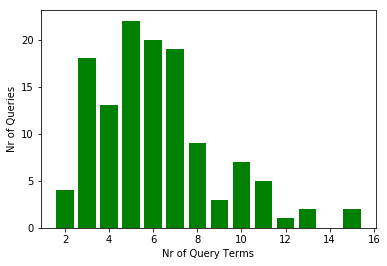

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.bar(list(query_lengths_counter.keys()), query_lengths_counter.values(), color='g')
plt.xlabel("Nr of Query Terms")
plt.ylabel("Nr of Queries")
plt.show()

4. What type of queries were there?

To be able to answer this question I follow the work by Padigela et al (2019). They make use of the answer type classifier found here: https://github.com/superscriptjs/qtypes

I make use of the query text file I made at the previous question and feed it to a special .js script I wrote that uses the answer type classifier to compute the answer type for each query. The output is stored in a file named "firebase_answer_types.txt" so lets load that.

In [20]:
firebase_answer_types = {}
counter_answer_types = 0
counter_no_answer_types = 0
with open("firebase_answer_types.txt", "r") as infile:
    for line in infile:
        if("\t" in line.rstrip()):
            counter_answer_types += 1
            [query_text,answer_type] = line.rstrip().split("\t")
            firebase_answer_types[query_text] = answer_type.split(":")[0]
        else:
            if not line.rstrip() == "":
                counter_no_answer_types += 1
                firebase_answer_types[line.rstrip()] = ""

In [21]:
print("There are %s queries for which no answer type could be classified."%(counter_no_answer_types))

There are 54 queries for which no answer type could be classified.


In [22]:
for query_text, answer_type in firebase_answer_types.items():
    if answer_type == "":
        print(query_text)

rigorous testing definition
is cortana smart???
neonatal hemochromatosis causes
definition of purse
definition, nepotism
how big is a micron
molar mass of phenol
who is the boss of google?
phone number for bc transit junction
temperature diode
can vcenter standard manage essentials plus
how could the courts check the bureaucracy
weather in fletcher,nc
why food products or food contaminated wastes cannot be recycled?
statute of limitations definition
carnationï¿½ evaporated milk total calories
effects hot stone has on the circulatory system
how far is niagara on the lake to hamilton
linking verb synonym
hydrocodone price per pill
what's the difference between jambalaya and paella
difference between watt and hertz
highest mileage crossover india
was the great wall of china breached
has a mlb team ever gone undefeated in the regular season
____________________ is considered the father of modern medicine.
blue sky charge controller price
_______ sediments originate from elements in seawate

Now with help of this list: https://cogcomp.seas.upenn.edu/Data/QA/QC/definition.html I am going to manually label these answer types.

In [23]:
with open("manual_answer_types.txt", "r", encoding='utf-8') as infile:
    for line in infile:
        [query_text,answer_type] = line.rstrip().split("\t")
        firebase_answer_types[query_text] = answer_type

In [24]:
for query_text, answer_type in firebase_answer_types.items():
    if answer_type == "":
        print(query_text)

In [25]:
answer_types = list(firebase_answer_types.values())

In [26]:
answer_types_counts = Counter(answer_types)

In [27]:
answer_types_counts

Counter({'DESC': 74, 'ENTY': 2, 'HUM': 12, 'LOC': 9, 'NUM': 28})

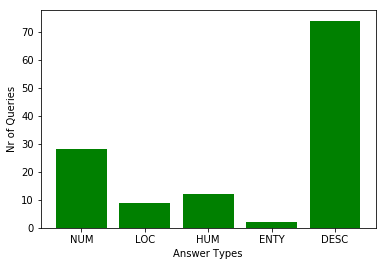

In [28]:
plt.bar(list(answer_types_counts.keys()), answer_types_counts.values(), color='g')
plt.xlabel("Answer Types")
plt.ylabel("Nr of Queries")
plt.show()

There are no abbreviation questions in the dataset. Most answer types are **Description** followed by **Numeric**. According to the research by Padigela et al (2019) BERT seems to have the lowest performance on Numeric questions. It will be interesting to see if this is the case with my research.

5. How many queries had the MS MARCO relevant passage in the top 20?

To answer this question we need the output from Anserini's BM25 on the development set with hits=100. And we need MS MARCO qrels file for the development set. We then merge these files to find the ms marco relevant passage in each top 100. Then we filter on <21 to get the top20 for each query and check how many of these top20's contain the ms marco relevant passage.

In [29]:
bm25_subset_df = bm25_df[bm25_df['query_id'].isin(query_ids)].copy()

In [30]:
qrels_subset_df = qrels_df[qrels_df['query_id'].isin(query_ids)].copy()

In [31]:
result = pd.merge(bm25_subset_df, qrels_subset_df, on=['query_id','passage_id'],how='left')

In [32]:
result = result.dropna()

In [33]:
print("There are %s queries with the ms marco relevant passage in the top 20 by BM25."%(len(result[result['bm25_rank'] < 21])))

There are 118 queries with the ms marco relevant passage in the top 20 by BM25.


# Assessor Statistics

1. How many assessors contributed?

In [34]:
assessor_ids = []
for query_id in query_ids:
    df = dataframes[query_id]
    nr_assessors = assessor_data[query_id]
    user_id_columns = ["user%s_id"%(i+1) for i in range(nr_assessors)]
    for user_id_column in user_id_columns:
        user_id = list(np.unique(df[user_id_column].values.tolist()))[0]
        if not user_id in assessor_ids:
            assessor_ids.append(user_id)

In [35]:
print("The number of assessors is %s."%(len(assessor_ids)))

The number of assessors is 37.


2. How was there English level?

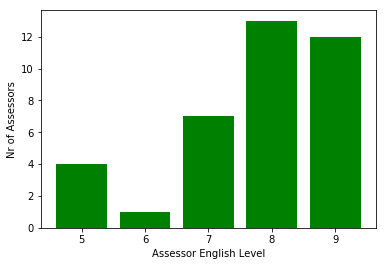

In [36]:
english_levels = assessor_df['english'].values.tolist()
level_counts = Counter(english_levels)
plt.bar(list(level_counts.keys()), level_counts.values(), color='g')
plt.xlabel("Assessor English Level")
plt.ylabel("Nr of Assessors")
plt.show()

In [37]:
level_counts

Counter({5: 4, 6: 1, 7: 7, 8: 13, 9: 12})

3. Did any low English level (<6) assessors assess the same queries?

We will need to filter on the assessors with an english level of below 7 and see if they assessed the same queries.

In [38]:
import ast

low_level_assessors_df = assessor_df[assessor_df['english'] < 7]

query_assessor_dict = {}

for index, row in low_level_assessors_df.iterrows():
    user_id = row['user_id']
    assessed_queries = ast.literal_eval(row['assessed_queries'])
    for query_id in assessed_queries:
        if not query_id in query_assessor_dict.keys():
            query_assessor_dict[query_id] = [user_id]
        else:
            qeury_assessor_dict[query_id].append(user_id)

In [39]:
query_assessor_dict

{'1006199': ['VuW5Bs9hZ5QYshUJICGGdMRJE803'],
 '1007473': ['RIH7GordAScQ8PxzXHptOYhe5La2'],
 '1040461': ['VuW5Bs9hZ5QYshUJICGGdMRJE803'],
 '1045227': ['RIH7GordAScQ8PxzXHptOYhe5La2'],
 '1046648': ['RIH7GordAScQ8PxzXHptOYhe5La2'],
 '1056446': ['VuW5Bs9hZ5QYshUJICGGdMRJE803'],
 '1065558': ['RIH7GordAScQ8PxzXHptOYhe5La2'],
 '1077356': ['IEem2CuVB8U5paYaSJPyxZML0lJ2'],
 '1083663': ['RIH7GordAScQ8PxzXHptOYhe5La2'],
 '1083852': ['IEem2CuVB8U5paYaSJPyxZML0lJ2'],
 '1085457': ['v1PE6B964Jd7CdtcUM26gX1giwe2'],
 '1088541': ['IEem2CuVB8U5paYaSJPyxZML0lJ2'],
 '1091688': ['VuW5Bs9hZ5QYshUJICGGdMRJE803'],
 '1095278': ['v1PE6B964Jd7CdtcUM26gX1giwe2'],
 '117113': ['IEem2CuVB8U5paYaSJPyxZML0lJ2'],
 '149161': ['RIH7GordAScQ8PxzXHptOYhe5La2'],
 '178468': ['IEem2CuVB8U5paYaSJPyxZML0lJ2'],
 '202306': ['Edf7tjdNpAYDtdJnkKkgrR11BDZ2'],
 '208494': ['Edf7tjdNpAYDtdJnkKkgrR11BDZ2'],
 '231877': ['RIH7GordAScQ8PxzXHptOYhe5La2'],
 '30860': ['Edf7tjdNpAYDtdJnkKkgrR11BDZ2'],
 '321951': ['VuW5Bs9hZ5QYshUJICGGdMRJE803'

As you can see each query only has one low english level user id connected to it. This means that no query id has been assessed by more than 1 low level english assessor.

4. How many queries did each assessor assess?

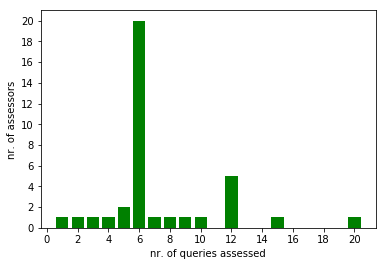

In [40]:
progress_numbers = assessor_df['progress'].values.tolist()
progress_counter = Counter(progress_numbers)
plt.bar(list(progress_counter.keys()), progress_counter.values(), color='g')
plt.xlabel("nr. of queries assessed")
plt.ylabel("nr. of assessors")
plt.xticks(np.arange(0, 22, 2.0))
plt.yticks(np.arange(0, 22, 2.0))
plt.show()

5. How many queries are assessed by low English level assessors?

In [41]:
queries_assessed_by_low_english_level_assessors = []
for index, row in low_level_assessors_df.iterrows():
    user_id = row['user_id']
    assessed_queries = ast.literal_eval(row['assessed_queries'])
    for query_id in assessed_queries:
        if not query_id in queries_assessed_by_low_english_level_assessors:
            queries_assessed_by_low_english_level_assessors.append(query_id)

In [42]:
print("There are %s queries assessed by low English level assessors."%(len(queries_assessed_by_low_english_level_assessors)))

There are 40 queries assessed by low English level assessors.


5. How many queries are assessed by low English level assessors and have at least 3 assessors?

In [43]:
low_english_level_users = list(np.unique(low_level_assessors_df['user_id'].values.tolist()))
counter = 0
for query_id in query_ids:
    df = dataframes[query_id]
    nr_assessors = assessor_data[query_id]
    user_id_columns = ["user%s_id"%(i+1) for i in range(nr_assessors)]
    if nr_assessors >= 3:
        for user_id_column in user_id_columns:
            if df[user_id_column][0] in low_english_level_users:
                counter += 1
print("There are %s queries with at least 3 assessors and of which one is a low english level assessor."%(counter))

There are 23 queries with at least 3 assessors and of which one is a low english level assessor.


6. What is the number of assessors per query? 

In [44]:
assessor_counts = Counter(list(assessor_data.values()))
print(assessor_counts)

Counter({1: 57, 3: 41, 2: 17, 5: 5, 6: 2, 7: 2, 4: 1})


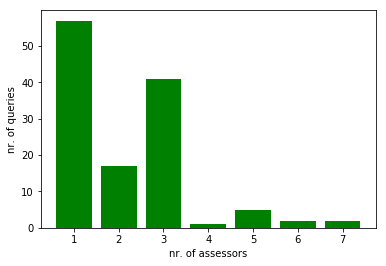

In [45]:
plt.bar(list(assessor_counts.keys()), assessor_counts.values(), color='g')
plt.xlabel("nr. of assessors")
plt.ylabel("nr. of queries")
#plt.xticks(np.arange(0, 22, 2.0))
#plt.yticks(np.arange(0, 22, 2.0))
plt.show()

In [46]:
(57+17)/125

0.592

In [47]:
(41+5+3+1+1)/125

0.408

# Assessment Statistics

1. Are there any missing data?

In [48]:
queries_with_missing_data = []
counter = 0
for query_id in query_ids:
    df = dataframes[query_id]
    if 'no_input' in df.values:
        counter += 1
        print(query_id)
        queries_with_missing_data.append(query_id)
print("nr of queries with missing data: %s"%(counter))

1077356
993153
38946
825147
785176
973362
971653
1096257
1045826
904389
1083852
426442
988142
758519
689885
257885
1097449
92542
1101714
637459
202306
736125
nr of queries with missing data: 22


In [49]:
queries_with_missing_data = []
counter = 0
for query_id in query_ids:
    df = dataframes[query_id]
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        if 'no_input' in df.values:
            counter += 1
            print(query_id)
            queries_with_missing_data.append(query_id)
print("nr of queries (with at least 3 assessors) with missing data: %s"%(counter))

1077356
993153
825147
1096257
904389
426442
758519
689885
1097449
92542
202306
nr of queries (with at least 3 assessors) with missing data: 11


Lets see how many data is missing per user per query

In [50]:
for query_id in queries_with_missing_data:
    print(query_id)
    df = dataframes[query_id]
    nr_assessors = assessor_data[query_id]
    user_id_columns = ["user%s_label"%(i+1) for i in range(nr_assessors)]
    for user_id_column in user_id_columns:
        print(user_id_column)
        print(len(df[df[user_id_column].isin(["no_input"])]))
    print("\n")

1077356
user1_label
1
user2_label
0
user3_label
0


993153
user1_label
0
user2_label
19
user3_label
1
user4_label
0
user5_label
0
user6_label
0
user7_label
0


825147
user1_label
0
user2_label
0
user3_label
1
user4_label
0
user5_label
0


1096257
user1_label
0
user2_label
1
user3_label
0


904389
user1_label
0
user2_label
0
user3_label
1


426442
user1_label
0
user2_label
3
user3_label
0


758519
user1_label
0
user2_label
1
user3_label
0


689885
user1_label
1
user2_label
0
user3_label
0


1097449
user1_label
0
user2_label
0
user3_label
0
user4_label
1
user5_label
0
user6_label
0
user7_label
0


92542
user1_label
0
user2_label
0
user3_label
1


202306
user1_label
0
user2_label
1
user3_label
0




Most of the times it is just one data entry. Except for query 993153 for which user 2 only entered one label. We could either remove this query entirely from the dataset or we could just leave out the input from user 2 as there are 6 other assessors for this query. I will do the latter.

In [51]:
del dataframes['993153']['user2_label']
del dataframes['993153']['user2_id']

In [52]:
assessor_data['993153'] = 6

In [53]:
nr_assessors = assessor_data['993153']
user_column_names = []
for i in range(nr_assessors):
    user_column_names = user_column_names + ["user%s_id"%(i+1), "user%s_label"%(i+1)]
dataframes['993153'].columns = ['query_id','passageid','msmarco'] + user_column_names

In [54]:
dataframes['993153']

,query_id,passageid,msmarco,user1_id,user1_label,user2_id,user2_label,user3_id,user3_label,user4_id,user4_label,user5_id,user5_label,user6_id,user6_label
0,993153,8174479,irrelevant,AdqXiUfSnyZTKzaEEUtz4JrITjD2,1,XqZsRA3c3QQdWbsJ27oEs8plMYl2,1,bJ8IzR4NOPRXuDFEBVpiTZzdxUG2,2,jIAS83dqkiWODrjmPAvj8CIfsYP2,1,stmaxqNmmMPHcRWGv2BsI6tp0rH3,2,xkVAJ8mrGPUrhBPQC38nFa6Q3Za2,1
1,993153,447864,irrelevant,AdqXiUfSnyZTKzaEEUtz4JrITjD2,1,XqZsRA3c3QQdWbsJ27oEs8plMYl2,1,bJ8IzR4NOPRXuDFEBVpiTZzdxUG2,1,jIAS83dqkiWODrjmPAvj8CIfsYP2,1,stmaxqNmmMPHcRWGv2BsI6tp0rH3,1,xkVAJ8mrGPUrhBPQC38nFa6Q3Za2,1
2,993153,931774,irrelevant,AdqXiUfSnyZTKzaEEUtz4JrITjD2,1,XqZsRA3c3QQdWbsJ27oEs8plMYl2,1,bJ8IzR4NOPRXuDFEBVpiTZzdxUG2,1,jIAS83dqkiWODrjmPAvj8CIfsYP2,1,stmaxqNmmMPHcRWGv2BsI6tp0rH3,1,xkVAJ8mrGPUrhBPQC38nFa6Q3Za2,1
3,993153,7278030,relevant,AdqXiUfSnyZTKzaEEUtz4JrITjD2,1,XqZsRA3c3QQdWbsJ27oEs8plMYl2,5,bJ8IzR4NOPRXuDFEBVpiTZzdxUG2,5,jIAS83dqkiWODrjmPAvj8CIfsYP2,4,stmaxqNmmMPHcRWGv2BsI6tp0rH3,5,xkVAJ8mrGPUrhBPQC38nFa6Q3Za2,5
4,993153,6874487,irrelevant,AdqXiUfSnyZTKzaEEUtz4JrITjD2,1,XqZsRA3c3QQdWbsJ27oEs8plMYl2,1,bJ8IzR4NOPRXuDFEBVpiTZzdxUG2,1,jIAS83dqkiWODrjmPAvj8CIfsYP2,1,stmaxqNmmMPHcRWGv2BsI6tp0rH3,2,xkVAJ8mrGPUrhBPQC38nFa6Q3Za2,1
5,993153,6304514,irrelevant,AdqXiUfSnyZTKzaEEUtz4JrITjD2,1,XqZsRA3c3QQdWbsJ27oEs8plMYl2,1,bJ8IzR4NOPRXuDFEBVpiTZzdxUG2,2,jIAS83dqkiWODrjmPAvj8CIfsYP2,1,stmaxqNmmMPHcRWGv2BsI6tp0rH3,1,xkVAJ8mrGPUrhBPQC38nFa6Q3Za2,1
6,993153,2100087,irrelevant,AdqXiUfSnyZTKzaEEUtz4JrITjD2,1,XqZsRA3c3QQdWbsJ27oEs8plMYl2,3,bJ8IzR4NOPRXuDFEBVpiTZzdxUG2,2,jIAS83dqkiWODrjmPAvj8CIfsYP2,3,stmaxqNmmMPHcRWGv2BsI6tp0rH3,4,xkVAJ8mrGPUrhBPQC38nFa6Q3Za2,3
7,993153,6160228,irrelevant,AdqXiUfSnyZTKzaEEUtz4JrITjD2,1,XqZsRA3c3QQdWbsJ27oEs8plMYl2,1,bJ8IzR4NOPRXuDFEBVpiTZzdxUG2,2,jIAS83dqkiWODrjmPAvj8CIfsYP2,1,stmaxqNmmMPHcRWGv2BsI6tp0rH3,3,xkVAJ8mrGPUrhBPQC38nFa6Q3Za2,2
8,993153,2565447,irrelevant,AdqXiUfSnyZTKzaEEUtz4JrITjD2,1,XqZsRA3c3QQdWbsJ27oEs8plMYl2,no_input,bJ8IzR4NOPRXuDFEBVpiTZzdxUG2,1,jIAS83dqkiWODrjmPAvj8CIfsYP2,1,stmaxqNmmMPHcRWGv2BsI6tp0rH3,2,xkVAJ8mrGPUrhBPQC38nFa6Q3Za2,1
9,993153,6818707,irrelevant,AdqXiUfSnyZTKzaEEUtz4JrITjD2,1,XqZsRA3c3QQdWbsJ27oEs8plMYl2,4,bJ8IzR4NOPRXuDFEBVpiTZzdxUG2,4,jIAS83dqkiWODrjmPAvj8CIfsYP2,1,stmaxqNmmMPHcRWGv2BsI6tp0rH3,3,xkVAJ8mrGPUrhBPQC38nFa6Q3Za2,1


2. How many times do the assessors disagree with the MS MARCO label (graded)?

Go over all dataframes and take the row where the msmarco label is 'relevant'. Compute the agreement under the assessors and check if they get the same label as ms marco. In case of graded relevance assume that 'relevant' can mean anything but a grade of 1. 

In [55]:
def str2int(labels):
    integer_labels = []
    for label in labels:
        if not label == "no_input":
            integer_labels.append(int(label))
    return integer_labels

In [56]:
def getAgreementLabel(labels):
    return int(np.ceil(np.median(labels)))

In [57]:
def toNum(label):
    if label == "irrelevant":
        return 1
    else:
        return 5

In [58]:
counter_no_relevant_in_top_20 = 0
counter_disagreement = 0
for query_id in query_ids:
    df = dataframes[query_id]
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        relevant_row = df.loc[df['msmarco'] == 'relevant']
        if not len(relevant_row) == 0:
            assessor_labels = relevant_row.iloc[:,4::2].values[0]
            integer_labels = str2int(assessor_labels)
            agreement_label = getAgreementLabel(integer_labels)
            relevant_row['agreement_label'] = agreement_label
            relevant_row['msmarco'] = toNum(relevant_row['msmarco'].values)
            [msmarco_label, agreement_label] = relevant_row[['msmarco','agreement_label']].values[0]
            if agreement_label == 1:
                print(query_id)
                counter_disagreement += 1
        else:
            counter_no_relevant_in_top_20 += 1

540906
427323
993987


c:\users\tomjg\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
c:\users\tomjg\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [59]:
print("There are %s queries for which there is disagreement among the assessors and the MS MARCO relevant label"%(counter_disagreement))

There are 3 queries for which there is disagreement among the assessors and the MS MARCO relevant label


In [61]:
print("There are %s queries for which the ms marco relevant passage is not in the top 20 and there are 3 assessors"%(counter_no_relevant_in_top_20))

There are 3 queries for which the ms marco relevant passage is not in the top 20 and there are 3 assessors


3. How many times do the assessors disagree with the MS MARCO label (binary threshold=2)?

In [62]:
# < 2 is irrelevant >= 2 is relevant
binary_threshold = 2

In [63]:
def getListUserLabelColumns(nr_assessors):
    label_columns = []
    for i in range(nr_assessors):
        label_columns.append("user%s_label"%(i+1))
    return label_columns

In [64]:
def makeBinary(labels):
    binary_labels = []
    for label in labels:
        if not label == "no_input":
            if int(label) < binary_threshold:
                binary_labels.append(0)
            else:
                binary_labels.append(1)
        else:
            binary_labels.append(label)
    return binary_labels

In [65]:
def getAgreementLabel(msmarco_label,labels):
    if "no_input" in labels:
        labels.remove('no_input')
        if usersDoAgree(labels):
            return labels[0]
        else:
            return performMajorityVote(msmarco_label,labels)
    else:
        if usersDoAgree(labels):
            return labels[0]
        else:
            return performMajorityVote(msmarco_label,labels)

In [66]:
def usersDoAgree(labels):
    if len(set(labels)) == 1:
        return True
    else:
        return False

In [67]:
def performMajorityVote(msmarco_label,labels):
    count_votes = Counter(labels)
    majority_label = msmarco_label
    if (len(labels) % 2) == 0:
        vote_threshold = int(len(labels)/2)
        for label,votes in count_votes.items():
            if votes > vote_threshold:
                majority_label = label
    else:
        vote_threshold = int(np.ceil(len(labels)/2))
        for label, votes in count_votes.items():
            if votes >= vote_threshold:
                majority_label = label
    return majority_label

In [68]:
counter_disagreement = 0
for query_id in query_ids:
    df = dataframes[query_id]
    agreement_labels = []
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        relevant_row = df.loc[df['msmarco'] == 'relevant']
        if not len(relevant_row) == 0:
            relevant_row['msmarco_binary'] = relevant_row['msmarco'].apply(lambda x: 0 if (x == 'irrelevant') else 1)
            user_labels = relevant_row[getListUserLabelColumns(nr_assessors)].values[0]
            binary_labels = makeBinary(user_labels)
            agreement_label = getAgreementLabel(relevant_row['msmarco_binary'],binary_labels)
            if agreement_label == 0:
                print(query_id)
                counter_disagreement += 1

540906
427323
993987


c:\users\tomjg\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [69]:
print("There are %s queries for which there is disagreement among the assessors and the MS MARCO relevant label"%(counter_disagreement))

There are 3 queries for which there is disagreement among the assessors and the MS MARCO relevant label


4. How many times do the assessors disagree with the MS MARCO label (binary thrheshold=3)?

In [70]:
# < 3 is irrelevant >= 3 is relevant
binary_threshold = 3

In [71]:
def getListUserLabelColumns(nr_assessors):
    label_columns = []
    for i in range(nr_assessors):
        label_columns.append("user%s_label"%(i+1))
    return label_columns

In [72]:
def makeBinary(labels):
    binary_labels = []
    for label in labels:
        if not label == "no_input":
            if int(label) < binary_threshold:
                binary_labels.append(0)
            else:
                binary_labels.append(1)
        else:
            binary_labels.append(label)
    return binary_labels

In [73]:
def getAgreementLabel(msmarco_label,labels):
    if "no_input" in labels:
        labels.remove('no_input')
        if usersDoAgree(labels):
            return labels[0]
        else:
            return performMajorityVote(msmarco_label,labels)
    else:
        if usersDoAgree(labels):
            return labels[0]
        else:
            return performMajorityVote(msmarco_label,labels)

In [74]:
def usersDoAgree(labels):
    if len(set(labels)) == 1:
        return True
    else:
        return False

In [75]:
def performMajorityVote(msmarco_label,labels):
    count_votes = Counter(labels)
    majority_label = msmarco_label
    if (len(labels) % 2) == 0:
        vote_threshold = int(len(labels)/2)
        for label,votes in count_votes.items():
            if votes > vote_threshold:
                majority_label = label
    else:
        vote_threshold = int(np.ceil(len(labels)/2))
        for label, votes in count_votes.items():
            if votes >= vote_threshold:
                majority_label = label
    return majority_label

In [76]:
counter_disagreement = 0
for query_id in query_ids:
    df = dataframes[query_id]
    agreement_labels = []
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        relevant_row = df.loc[df['msmarco'] == 'relevant']
        if not len(relevant_row) == 0:
            relevant_row['msmarco_binary'] = relevant_row['msmarco'].apply(lambda x: 0 if (x == 'irrelevant') else 1)
            user_labels = relevant_row[getListUserLabelColumns(nr_assessors)].values[0]
            binary_labels = makeBinary(user_labels)
            agreement_label = getAgreementLabel(relevant_row['msmarco_binary'],binary_labels)
            if agreement_label == 0:
                print(query_id)
                counter_disagreement += 1

838453
540906
321951
427323
993987
866251


c:\users\tomjg\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [77]:
print("There are %s queries for which there is disagreement among the assessors and the MS MARCO relevant label"%(counter_disagreement))

There are 6 queries for which there is disagreement among the assessors and the MS MARCO relevant label


5. How many times is the MS MARCO relevant passage the only relevant (graded)?

To be able to compute this we will need to find all those queries for which all but the ms marco relevant passage have a graded relevance label of 1.

In [78]:
def getListUserLabelColumns(nr_assessors):
    label_columns = []
    for i in range(nr_assessors):
        label_columns.append("user%s_label"%(i+1))
    return label_columns

In [79]:
def str2int(labels):
    integer_labels = []
    for label in labels:
        if not label == "no_input":
            integer_labels.append(int(label))
    return integer_labels

In [80]:
def getAgreementLabel(labels):
    return int(np.ceil(np.median(labels)))

In [81]:
count_cases_where_only_ms_relevant = 0
for query_id in query_ids:
    df = dataframes[query_id]
    agreement_labels = []
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        for index, row in df.iterrows():
            user_labels = row[getListUserLabelColumns(nr_assessors)].values
            integer_labels = str2int(user_labels)
            agreement_label = getAgreementLabel(integer_labels)
            agreement_labels.append(agreement_label)
        df['agreement_label'] = agreement_labels
        unique_labels = set(df[df['msmarco'] == 'irrelevant']['agreement_label'].values.tolist())
        if len(unique_labels) == 1 and unique_labels[0] == 1:
            count_cases_where_only_ms_relevant += 1

In [82]:
print("There are %s queries for which only the ms marco relevant passage is assessed as relevant."%(count_cases_where_only_ms_relevant))

There are 0 queries for which only the ms marco relevant passage is assessed as relevant.


6. How many times is the MS MARCO relevant passage the only relevant (binary threshold=2)?

In [83]:
for query_id in query_ids:
    df = dataframes[query_id]
    df['msmarco_binary'] = df['msmarco'].apply(lambda x: 0 if (x == 'irrelevant') else 1)

In [84]:
# < 2 is irrelevant >= 2 is relevant
binary_threshold = 2

In [85]:
def makeBinary(labels):
    binary_labels = []
    for label in labels:
        if not label == "no_input":
            if int(label) < binary_threshold:
                binary_labels.append(0)
            else:
                binary_labels.append(1)
        else:
            binary_labels.append(label)
    return binary_labels

In [86]:
def getListUserLabelColumns(nr_assessors):
    label_columns = []
    for i in range(nr_assessors):
        label_columns.append("user%s_label"%(i+1))
    return label_columns

In [87]:
def getAgreementLabel(msmarco_label,labels):
    if "no_input" in labels:
        labels.remove('no_input')
        if usersDoAgree(labels):
            return labels[0]
        else:
            return performMajorityVote(msmarco_label,labels)
    else:
        if usersDoAgree(labels):
            return labels[0]
        else:
            return performMajorityVote(msmarco_label,labels)

In [88]:
def usersDoAgree(labels):
    if len(set(labels)) == 1:
        return True
    else:
        return False

In [89]:
def performMajorityVote(msmarco_label,labels):
    count_votes = Counter(labels)
    majority_label = msmarco_label
    if (len(labels) % 2) == 0:
        vote_threshold = int(len(labels)/2)
        for label,votes in count_votes.items():
            if votes > vote_threshold:
                majority_label = label
    else:
        vote_threshold = int(np.ceil(len(labels)/2))
        for label, votes in count_votes.items():
            if votes >= vote_threshold:
                majority_label = label
    return majority_label

In [90]:
count_cases_where_only_ms_relevant = 0
for query_id in query_ids:
    df = dataframes[query_id]
    agreement_labels = []
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        for index, row in df.iterrows():
            user_labels = row[getListUserLabelColumns(nr_assessors)].values
            binary_labels = makeBinary(user_labels)
            agreement_label = getAgreementLabel(row['msmarco_binary'],binary_labels)
            agreement_labels.append(agreement_label)
        df['agreement_label'] = agreement_labels
        if (len(df[(df['msmarco_binary'] == 1) & (df['agreement_label'] == 1)]) == 1):
            if(sum(df[df['msmarco_binary'] == 0]['agreement_label'].values.tolist()) == 0):
                count_cases_where_only_ms_relevant += 1
                print(query_id)

335710


In [91]:
print("There are %s queries for which the msmarco relevant passage is the only relevant passage after majority voting"%(count_cases_where_only_ms_relevant))

There are 1 queries for which the msmarco relevant passage is the only relevant passage after majority voting


7. How many times is the MS MARCO relevant passage the only relevant (binary thrheshold=3)?

In [92]:
for query_id in query_ids:
    df = dataframes[query_id]
    df['msmarco_binary'] = df['msmarco'].apply(lambda x: 0 if (x == 'irrelevant') else 1)

In [93]:
# < 3 is irrelevant >= 3 is relevant
binary_threshold = 3

In [94]:
def makeBinary(labels):
    binary_labels = []
    for label in labels:
        if not label == "no_input":
            if int(label) < binary_threshold:
                binary_labels.append(0)
            else:
                binary_labels.append(1)
        else:
            binary_labels.append(label)
    return binary_labels

In [95]:
def getListUserLabelColumns(nr_assessors):
    label_columns = []
    for i in range(nr_assessors):
        label_columns.append("user%s_label"%(i+1))
    return label_columns

In [96]:
def getAgreementLabel(msmarco_label,labels):
    if "no_input" in labels:
        labels.remove('no_input')
        if usersDoAgree(labels):
            return labels[0]
        else:
            return performMajorityVote(msmarco_label,labels)
    else:
        if usersDoAgree(labels):
            return labels[0]
        else:
            return performMajorityVote(msmarco_label,labels)

In [97]:
def usersDoAgree(labels):
    if len(set(labels)) == 1:
        return True
    else:
        return False

In [98]:
def performMajorityVote(msmarco_label,labels):
    count_votes = Counter(labels)
    majority_label = msmarco_label
    if (len(labels) % 2) == 0:
        vote_threshold = int(len(labels)/2)
        for label,votes in count_votes.items():
            if votes > vote_threshold:
                majority_label = label
    else:
        vote_threshold = int(np.ceil(len(labels)/2))
        for label, votes in count_votes.items():
            if votes >= vote_threshold:
                majority_label = label
    return majority_label

In [99]:
count_cases_where_only_ms_relevant = 0
for query_id in query_ids:
    df = dataframes[query_id]
    agreement_labels = []
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        for index, row in df.iterrows():
            user_labels = row[getListUserLabelColumns(nr_assessors)].values
            binary_labels = makeBinary(user_labels)
            agreement_label = getAgreementLabel(row['msmarco_binary'],binary_labels)
            agreement_labels.append(agreement_label)
        df['agreement_label'] = agreement_labels
        if (len(df[(df['msmarco_binary'] == 1) & (df['agreement_label'] == 1)]) == 1):
            if(sum(df[df['msmarco_binary'] == 0]['agreement_label'].values.tolist()) == 0):
                count_cases_where_only_ms_relevant += 1
                print(query_id)

335710
489257


In [100]:
print("There are %s queries for which the msmarco relevant passage is the only relevant passage after majority voting"%(count_cases_where_only_ms_relevant))

There are 2 queries for which the msmarco relevant passage is the only relevant passage after majority voting


8. What are the number of queries that can be used for experiments (graded; threshold=2; threshold=3)?

For the actual experiments there are a few criteria that will matter in order for a query to be used:

1. There should be at least 3 assessors.
2. The assessors should agree with the ms marco relevant passage.
3. The ms marco relevant passage should not be the only relevant passage after majority voting.

In [101]:
at_least_3 = []
for query_id in query_ids:
    df = dataframes[query_id]
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        at_least_3.append(query_id)

In [102]:
print("There are %s queries with at least 3 assessors."%(len(at_least_3)))

There are 51 queries with at least 3 assessors.


In [103]:
print("These are those queries:")
print(at_least_3)

These are those queries:
['54819', '1077356', '838453', '540906', '993153', '1095876', '242107', '321951', '178468', '9083', '1040461', '825147', '409143', '427323', '1083663', '212195', '1056446', '1006199', '1034595', '993987', '608323', '208822', '440362', '1096257', '30860', '741392', '414155', '687375', '904389', '335710', '149161', '866251', '1084469', '1003875', '426442', '785721', '341317', '117113', '1091688', '758519', '689885', '1097449', '831784', '1007473', '92542', '75266', '1049791', '202306', '1086248', '208494', '489257']


From above computations we know that the following queries do not met the other 2 criteria:

**Assessors do not agree with ms marco relevant passage:**

838453

866251

321951

427323

993987

540906

**Only have ms marco relevant passage as relevant:**

335710

489257

This means that if we remove those queries from the list we are left with 43 queries which we can use for experiments:

In [104]:
assessors_do_not_agree = ["838453", "866251", "321951", "427323", "993987", "540906"]
msmarco_only_relevant = ["335710", "489257"]

In [105]:
experiment_query_ids = [query_id for query_id in at_least_3 if (not (query_id in assessors_do_not_agree)) and (not (query_id in msmarco_only_relevant))]

In [106]:
len(experiment_query_ids)

43

# Experiment Dataset Stats

1. How many queries does the dataset contain?

In [107]:
len(query_ids)

125

In [108]:
assessors_do_not_agree = ["838453", "866251", "321951", "427323", "993987", "540906"]
msmarco_only_relevant = ["335710", "489257"]
at_least_3 = []
for query_id in query_ids:
    nr_assessors = assessor_data[query_id]
    if nr_assessors >= 3:
        at_least_3.append(query_id)

In [109]:
experiment_query_ids = [query_id for query_id in at_least_3 if (not (query_id in assessors_do_not_agree)) and (not (query_id in msmarco_only_relevant))]

In [110]:
print("There are %s queries in the final dataset used for my thesis."%(len(experiment_query_ids)))

There are 43 queries in the final dataset used for my thesis.


2. What is the number of assessors per query?

In [111]:
assessor_count_list = []
for query_id in experiment_query_ids:
    nr_assessors = assessor_data[query_id]
    assessor_count_list.append(nr_assessors)

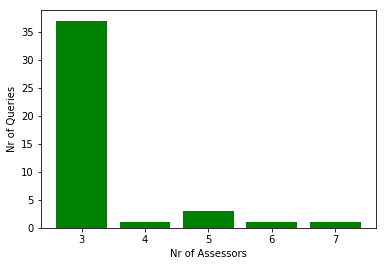

In [112]:
assessor_counts = Counter(assessor_count_list)
plt.bar(list(assessor_counts.keys()), assessor_counts.values(), color='g')
plt.xlabel("Nr of Assessors")
plt.ylabel("Nr of Queries")
plt.show()

In [113]:
assessor_counts

Counter({3: 37, 4: 1, 5: 3, 6: 1, 7: 1})

3. How many term does each query contain?

In [114]:
experiment_query_subset = query_subset[query_subset['query_id'].isin(experiment_query_ids)].copy()

In [115]:
experiment_query_subset.to_csv("experiment_query_subset.tsv",sep="\t", header=False,index=False)

In [116]:
experiment_query_texts = experiment_query_subset['query'].values.tolist()
with open("experiment_query_texts.txt","w") as outfile:
    for query_text in experiment_query_texts:
        outfile.write("%s\n"%(query_text))

In [117]:
query_texts = experiment_query_subset['query'].values.tolist()

In [118]:
query_lengths = []
for query_text in query_texts:
    query_lengths.append(len(query_text.split()))
query_lengths_counter = Counter(query_lengths)

In [119]:
query_lengths_counter

Counter({3: 3,
         4: 3,
         5: 9,
         6: 11,
         7: 6,
         8: 4,
         9: 1,
         10: 2,
         11: 2,
         12: 1,
         15: 1})

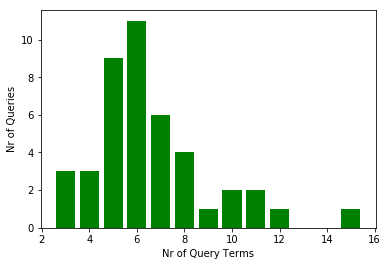

In [120]:
plt.bar(list(query_lengths_counter.keys()), query_lengths_counter.values(), color='g')
plt.xlabel("Nr of Query Terms")
plt.ylabel("Nr of Queries")
plt.show()

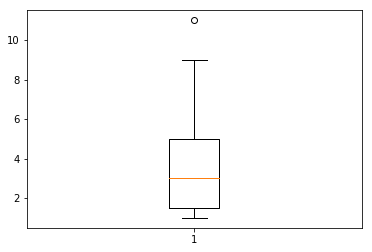

In [121]:
plt.boxplot(list(query_lengths_counter.values()))
plt.show()

In [122]:
np.median(list(query_lengths_counter.values()))

3.0

4. What type of queries does the dataset contain?

In [123]:
experiment_answer_types = {}
counter_answer_types = 0
counter_no_answer_types = 0
with open("experiment_answer_types.txt", "r") as infile:
    for line in infile:
        if("\t" in line.rstrip()):
            counter_answer_types += 1
            [query_text,answer_type] = line.rstrip().split("\t")
            experiment_answer_types[query_text] = answer_type.split(":")[0]
        else:
            if not line.rstrip() == "":
                counter_no_answer_types += 1
                experiment_answer_types[line.rstrip()] = ""

In [124]:
print("There are %s queries for which no answer type could be classified."%(counter_no_answer_types))

There are 20 queries for which no answer type could be classified.


In [125]:
with open("manual_answer_types.txt", "r", encoding='utf-8') as infile:
    for line in infile:
        [query_text,answer_type] = line.rstrip().split("\t")
        if query_text in experiment_answer_types.keys():
            experiment_answer_types[query_text] = answer_type

In [126]:
for query_text, answer_type in experiment_answer_types.items():
    if answer_type == "":
        print(query_text)

In [127]:
answer_types = list(experiment_answer_types.values())
answer_types_counts = Counter(answer_types)

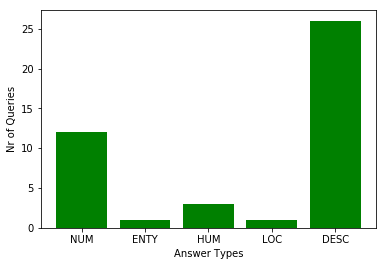

In [128]:
plt.bar(list(answer_types_counts.keys()), answer_types_counts.values(), color='g')
plt.xlabel("Answer Types")
plt.ylabel("Nr of Queries")
plt.show()

In [129]:
answer_types_counts

Counter({'DESC': 26, 'ENTY': 1, 'HUM': 3, 'LOC': 1, 'NUM': 12})

5. How many queries have the MS MARCO relevant passage in the top 20?

In [130]:
bm25_subset_df = bm25_df[bm25_df['query_id'].isin(experiment_query_ids)].copy()
qrels_subset_df = qrels_df[qrels_df['query_id'].isin(experiment_query_ids)].copy()
result = pd.merge(bm25_subset_df, qrels_subset_df, on=['query_id','passage_id'],how='left')
result = result.dropna()
print("There are %s queries with the ms marco relevant passage in the top 20 by BM25."%(len(result[result['bm25_rank'] < 21])))

There are 40 queries with the ms marco relevant passage in the top 20 by BM25.


6. How many queries are assessed by low English level assessors?

In [131]:
low_level_assessors_df = assessor_df[assessor_df['english'] < 7]
low_english_level_users = list(np.unique(low_level_assessors_df['user_id'].values.tolist()))
counter = 0
for query_id in experiment_query_ids:
    df = dataframes[query_id]
    nr_assessors = assessor_data[query_id]
    user_id_columns = ["user%s_id"%(i+1) for i in range(nr_assessors)]
    for user_id_column in user_id_columns:
        if df[user_id_column][0] in low_english_level_users:
            counter += 1
print("There are %s queries assessed by a low English level assessor."%(counter))

There are 21 queries assessed by a low English level assessor.
